# EXPLORATORY DATA ANALYSIS (I.)

In [4]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


In [5]:
data_raw = pd.read_csv('../../DATA/FINAL/transformed_set_enriched.csv')

C:\Users\matus.rohal\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3433: DtypeWarning: Columns (110) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 1. Shape and size

In [6]:
display(data_raw.shape)

(2114837, 135)

In [7]:
KEYS = [
    'entity_id',
    'financial_report_id',
    'financial_statement_id',
    'entity_ico',
    'entity_name']

DIMENSIONS = [
    'year',
    # 'month',
    # 'financial_report_order_number',
    'period_length',
    # 'consolidated',
    # 'approved_date',
    'type',
    'financial_report_template_id',
    # 'establishment_date',
    # 'cancellation_date',
    # 'sknace_code',
    # 'entity_state',
    'legal_form_code',
    'org_size_code',
    'ownership_category_code',
    'entity_consolidated',
    # 'sknace_division_name',
    'sknace_division',
    # 'sknace_subcategory',
    'sal_class',
    'is_outlier']

RAW_VALUES = [ 
    'total_assets',
    'non_current_assets',
    'non_current_intangible_assets',
    'non_current_tangible_assets',
    'non_current_financial_assets',
    'current_assets',
    'inventories',
    'non_current_receivables',
    'current_receivables',
    'financial_assets',
    'current_financial_assets',
    'cash_and_bank_balances',
    'total_equity_and_liabilities',
    'equity',
    'share_capital',
    'share_premium',
    'net_profit_of_previous_years',
    'net_profit_after_tax',
    'liabilities',
    'non_current_liabilities',
    'long_term_provisions',
    'long_term_bank_loans',
    'current_liabilities',
    'short_term_provisions',
    'current_bank_loans',
    'short_term_financial_assistance',
    'operating_revenues',
    'sales_from_the_merchandise',
    'sales_from_the_own_products_and_services',
    'sales_from_the_other',
    'other_revenues_from_operating_activities',
    'operating_costs',
    'costs_of_merchandise_sold',
    'consumed_materials_energy_non_inventory_supplies',
    'services',
    'personnel_costs',
    'taxes_and_fees',
    'depreciation',
    'remaining_cost_of_sold_long_term_assets_and_materials',
    'adjustments_to_receivables',
    'other_costs_of_operating_activities',
    'operating_result',
    'value_added',
    'revenues_from_financial_activities',
    'cost_of_financial_activities',
    'result_from_fincancial_activities',
    'result_before_tax',
    'income_tax',
    'result_after_tax']

PRIMARY_VALUES = [
    'CA',
    'CASH',
    'CL',
    'EQ',
    'NCL',
    'TA',
    'TL',
    'CC',
    'INV',
    'CF_NETTO',
    'CF_SELFFIN',
    'EAT',
    'EBIT',
    'SAL',
    'COST',
    'INT',
    'YIE',
    'LABOR']

RATIOS = [
    'L3',
    'L2',
    'L1',
    'CF_CL',
    'CASH_TA',
    'SAL_TA',
    'TL_SAL',
    'INV_COST',
    'INV_SAL',
    'CC_SAL',
    'TA_SAL',
    'TL_TA',
    'CF_TL',
    'CL_TA',
    'NCL_TA',
    'EQ_TL',
    'EQ_TA',
    'EBIT_INT',
    'CL_CC',
    'ROE',
    'EAT_TA',
    'ROA_BRUTTO',
    'CF_TA',
    'CF_SAL',
    'ROS',
    'EAT_YIE',
    'ROI',
    'ROA_NETTO',
    'LABOR_PRODUCTIVITY']

DISTRESS_SIGNALS = [
    'DPHZ_vat_registration_cancelled',
    'DPHZ_vat_registration_cancelled_1y_off',
    'DPHZ_vat_registration_cancelled_2y_off',
    'DPHZ_vat_registration_cancelled_3y_off',
    'RU_event',
    'RU_event_1y_off',
    'RU_event_2y_off',
    'RU_event_3y_off',
    'cancellation_year',
    'RUZ_cancelled',
    'RUZ_cancelled_1y_off',
    'RUZ_cancelled_2y_off',
    'RUZ_cancelled_3y_off']

In [8]:
data = data_raw.drop(columns=RAW_VALUES)
data_raw = None
display(data.shape)

(2114837, 86)

In [9]:
DIMENSIONS

['year',
 'period_length',
 'type',
 'financial_report_template_id',
 'legal_form_code',
 'org_size_code',
 'ownership_category_code',
 'entity_consolidated',
 'sknace_division',
 'sal_class',
 'is_outlier']

In [10]:
def sample_data(input_data):
    return (input_data
            .query('year > 2014 and period_length == 12 and year <= 2019')
            .sample(frac=1)
            .sort_values(['RU_event_3y_off', 'RUZ_cancelled_3y_off', 'financial_report_template_id'], ascending=[False, False, True])
            .groupby(['entity_id'])
            .first()
            .reset_index())

sample = sample_data(data.query('sal_class not in ["0. <50,000", "4. Veľký"] and ownership_category_code in [2, 7, 8] and sknace_division in ["G","M","C","F","N","L","J","H","Q","I","A"] and establishment_date <= "2013-01-01"'))
sample


,entity_id,year,month,financial_report_id,financial_report_template_id,CA,CASH,CL,EQ,NCL,TA,TL,CC,INV,CF_NETTO,CF_SELFFIN,EAT,EBIT,SAL,COST,INT,YIE,LABOR,L3,L2,L1,CF_CL,CASH_TA,SAL_TA,TL_SAL,INV_COST,INV_SAL,CC_SAL,TA_SAL,TL_TA,CF_TL,CL_TA,NCL_TA,EQ_TL,EQ_TA,EBIT_INT,CL_CC,ROE,EAT_TA,ROA_BRUTTO,CF_TA,CF_SAL,ROS,EAT_YIE,ROI,ROA_NETTO,LABOR_PRODUCTIVITY,financial_statement_id,financial_report_order_number,entity_ico,period_length,consolidated,approved_date,type,entity_name,establishment_date,cancellation_date,sknace_code,entity_state,legal_form_code,org_size_code,ownership_category_code,entity_consolidated,sknace_division_name,sknace_division,sknace_subcategory,DPHZ_vat_registration_cancelled,DPHZ_vat_registration_cancelled_1y_off,DPHZ_vat_registration_cancelled_2y_off,DPHZ_vat_registration_cancelled_3y_off,RU_event,RU_event_1y_off,RU_event_2y_off,RU_event_3y_off,cancellation_year,RUZ_cancelled,RUZ_cancelled_1y_off,RUZ_cancelled_2y_off,RUZ_cancelled_3y_off,sal_class,is_outlier
0,4.0,2017.0,1.0,6245237,699.0,3016170.0,1224056.0,2649399.0,268147.0,3224.0,3442598.0,2902134.0,1355249.0,1954.0,-1327325.0,-1211994.0,-1270731.0,-1386062.0,7651564.0,9093625.0,9037.0,7725983.0,3304021.0,1.138436,0.973543,0.462013,-0.500991,0.355562,2.222613,0.379286,0.077355,0.091934,0.177121,161.971498,0.843007,-0.457362,0.769593,0.000937,0.092396,0.077891,-152.376342,1.954917,-4.738934,-0.369120,-0.402621,-0.385559,-0.173471,-0.166075,-0.164475,-0.366495,-0.369120,0.431810,3662172.0,2.0,603783.0,12.0,NaN,2018-06-26,Riadna,"NESS Slovensko, a.s.",1991-01-17,None,62090.0,NaN,121.0,11.0,7.0,True,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,2. Malý,False
1,15.0,2019.0,1.0,7017229,699.0,2647003.0,10649.0,1747780.0,543564.0,260838.0,2862213.0,2310388.0,1265770.0,1294836.0,38920.0,35896.0,82.0,3106.0,11868803.0,11839845.0,21363.0,11869152.0,1175788.0,1.514494,0.730309,0.006093,0.022268,0.003721,4.146722,0.194661,39.370529,39.274471,0.106647,86.815552,0.807203,0.016846,0.610639,0.091132,0.235270,0.189910,1.145392,1.380804,0.000151,0.000029,0.001085,0.013598,0.003279,0.000007,0.000007,0.007492,0.000029,0.099065,4279047.0,3.0,643581.0,12.0,NaN,2020-04-27,Riadna,TERRASTROJ spol. s r.o.,1991-02-13,None,46630.0,NaN,112.0,11.0,8.0,False,"Veľkoobchod, okrem motorových vozidiel a motoc...",G,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,3. Stredný,False
2,67.0,2017.0,1.0,6173834,699.0,1010149.0,89993.0,838138.0,177776.0,29523.0,1056886.0,876497.0,445281.0,8596.0,32397.0,23744.0,15342.0,23995.0,1710704.0,1679701.0,3980.0,1710710.0,187871.0,1.205230,0.638647,0.107373,0.038654,0.085149,1.618627,0.512360,1.842328,1.808939,0.260291,222.410750,0.829320,0.036962,0.793026,0.027934,0.202826,0.168207,7.028894,1.882268,0.086300,0.014516,0.022703,0.030653,0.018938,0.008968,0.008968,0.018282,0.014516,0.109821,3605288.0,1.0,895920.0,12.0,NaN,2018-03-28,Riadna,TOR spol. s r.o.,1990-11-27,None,43910.0,NaN,112.0,7.0,2.0,False,Špecializované stavebné práce,F,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,1. Mikro,False
3,74.0,2015.0,1.0,5147116,699.0,5789288.0,271697.0,4022379.0,8280875.0,1210275.0,13795001.0,5302191.0,2238849.0,3278742.0,771839.0,543645.0,-242705.0,-203209.0,10133574.0,10211933.0,63478.0,10183492.0,2840799.0,1.439270,0.624145,0.067546,0.191886,0.019695,0.734583,0.523230,115.585083,116.478857,0.220934,490.073923,0.384356,0.145570,0.291582,0.087733,1.561784,0.600281,-2.201251,1.796628,-0.029309,-0.017594,-0.014731,0.055951,0.076167,-0.023951,-0.023833,-0.012992,-0.017594,0.280335,2777122.0,2.0,590797.0,12.0,NaN,2016-06-09,Riadna,"ZTS Sabinov, a. s.",1990-05-01,None,28150.0,NaN,121.0,22.0,2.0,False,Výroba strojov a zariadení i. n.,C,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,3. Stredný,False
4,133.0,2017.0,1.0,6142053,699.0,56844.0,18049.0,42257.0,11056.0,2811.0,57567.0,46511.0,19046.0,19749.0,2341.0,1381.0,1381.0,2341.0,215850.0,213256.0,1.0,215851.0,26259.0,1.345197,0.877843,0.427125,0.055399,0.313530,

In [11]:
for dim in DIMENSIONS:
    print(dim)
    display(sample[dim].value_counts())

year


2015.0    18496
2019.0    16577
2016.0    16260
2018.0    15414
2017.0    15124
Name: year, dtype: int64

period_length


12.0    81871
Name: period_length, dtype: int64

type


Riadna         81601
Mimoriadna       269
Kombinovaná        1
Name: type, dtype: int64

financial_report_template_id


687.0    43585
699.0    38286
Name: financial_report_template_id, dtype: int64

legal_form_code


112.0    78739
121.0     3132
Name: legal_form_code, dtype: int64

org_size_code


0.0     27641
2.0     14502
3.0     10204
4.0      9459
5.0      8639
6.0      4811
11.0     2192
1.0      1275
12.0     1133
7.0      1006
21.0      397
24.0      217
22.0      188
23.0      141
25.0       58
31.0        8
Name: org_size_code, dtype: int64

ownership_category_code


2.0    68874
7.0     9324
8.0     3673
Name: ownership_category_code, dtype: int64

entity_consolidated


False    81679
True       192
Name: entity_consolidated, dtype: int64

sknace_division


G    23406
M    12883
C     8724
F     7531
N     6269
L     5225
Q     4906
J     4090
H     3837
I     3140
A     1860
Name: sknace_division, dtype: int64

sal_class


1. Mikro      73648
2. Malý        6482
3. Stredný     1741
Name: sal_class, dtype: int64

is_outlier


False    80632
True      1239
Name: is_outlier, dtype: int64

In [12]:
def get_sample_sizes(data, row_label, column_label):
    samples_df = data.groupby([row_label, column_label])['financial_statement_id'].nunique().to_frame('count').reset_index()
    wide_df = pd.pivot_table(samples_df, index = row_label, columns=column_label, fill_value=0)
    return wide_df

In [13]:
sample['negative_equity'] = sample['EQ'] < 0
sample['negative_eat'] = sample['EAT'] < 0
sample['low_l3'] = sample['L3'] < 1
sample['low_eq_tl'] = sample['EQ_TL'] < 0.08


# pd.concat([
#     sample.groupby(['low_l3', 'negative_equity', 'low_eq_tl', 'negative_eat'])['RU_event_3y_off'].sum().to_frame('insolvency'),
#     sample.groupby(['low_l3', 'negative_equity', 'low_eq_tl', 'negative_eat'])['RUZ_cancelled_3y_off'].sum().to_frame('cancellation'),
#     sample.groupby(['low_l3', 'negative_equity', 'low_eq_tl', 'negative_eat'])['entity_id'].nunique().to_frame('total')], axis=1).reset_index()


#  'DPHZ_vat_registration_cancelled_2y_off',
#  'RUZ_cancelled_2y_off',
#  'RUZ_indirect_criterion_2y_off',
#  'RU_konkurz_2y_off',
#  'RU_ostatne_konania_2y_off',
#  'direct_criterion_2y_off'

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, ConfusionMatrixDisplay
import seaborn as sns

In [41]:
from itertools import chain, combinations
def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1)))



real_event = sample['RU_event_3y_off']
predictor = sample['low_eq_tl']

summary_list = []

for subset in all_subsets(['negative_equity', 'negative_eat', 'low_l3', 'low_eq_tl']):
    row = []
    row.append(subset)
    subset = list(subset)
    if len(subset) == 0: continue
    predictor = sample[subset.pop()]
    while subset:
        predictor = predictor * sample[subset.pop()]
    
    row.append(f1_score(real_event, predictor))
    row.append(accuracy_score(real_event, predictor))
    row.append(precision_score(real_event, predictor))
    row.append(recall_score(real_event, predictor))
    row.append(roc_auc_score(real_event, predictor))
    row.append(balanced_accuracy_score(real_event, predictor))
    
    summary_list.append(row)

summary_df = pd.DataFrame(summary_list, columns=['predictors_subset', 'f1', 'accuracy', 'precision', 'recall', 'roc_auc', 'balanced_accuracy'])
summary_df


,predictors_subset,f1,accuracy,precision,recall,roc_auc,balanced_accuracy
0,"(negative_equity,)",0.055330,0.809811,0.029488,0.447498,0.630937,0.630937
1,"(negative_eat,)",0.051370,0.723919,0.026833,0.600589,0.663031,0.663031
2,"(low_l3,)",0.038802,0.680485,0.020156,0.518155,0.600343,0.600343
3,"(low_eq_tl,)",0.051068,0.724921,0.026680,0.594701,0.660631,0.660631
4,"(negative_equity, negative_eat)",0.066709,0.875597,0.036790,0.357213,0.619672,0.619672
5,"(negative_equity, low_l3)",0.054771,0.839797,0.029556,0.372915,0.609298,0.609298
6,"(negative_equity, low_eq_tl)",0.055363,0.809933,0.029507,0.447498,0.630999,0.630999
7,"(negative_eat, low_l3)",0.058367,0.847480,0.031612,0.379784,0.616579,0.616579
8,"(negative_eat, low_eq_tl)",0.065434,0.845086,0.035373,0.435721,0.642983,0.642983
9,"(low_l3, low_eq_tl)",0.050440,0.798573,0.026792,0.429833,0.616527,0.616527


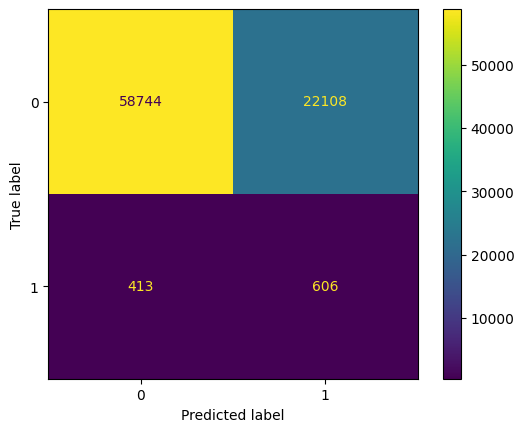

0.05106813297939578


In [25]:

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(real_event, predictor))
cm_display.plot()
plt.show()

print(f1_score(real_event, predictor))